In [ ]:
!pip -q install gymnasium

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import gymnasium as gym
import matplotlib.pyplot as plt

print("TF:", tf.__version__)

TF: 2.19.0


# Experiment 1: Reduce Training Epochs (epochs = 5)

In [ ]:
# Environment
env_name = "CartPole-v1"
env = gym.make(env_name)

# CartPole observation/action sizes
obs_dim = env.observation_space.shape[0]
num_actions = env.action_space.n

# === Experiment 1 change ===
epochs = 5   # was 30 in the original Keras example

# PPO hyperparameters (aligned with Keras example defaults)
steps_per_epoch = 4000
gamma = 0.99
clip_ratio = 0.2
policy_learning_rate = 3e-4
value_function_learning_rate = 1e-3
train_policy_iterations = 80
train_value_iterations = 80
lam = 0.97
target_kl = 0.01

# Network sizes (keep baseline for Experiment 1)
hidden_sizes = (64, 64)

print("obs_dim:", obs_dim, "num_actions:", num_actions)

obs_dim: 4 num_actions: 2


In [ ]:
def discounted_cumulative_sums(x, discount):
    """
    Computes discounted cumulative sums of vectors.
    output[i] = x[i] + discount*x[i+1] + discount^2*x[i+2] + ...
    """
    result = np.zeros_like(x, dtype=np.float32)
    running = 0.0
    for t in reversed(range(len(x))):
        running = x[t] + discount * running
        result[t] = running
    return result

def logprobabilities(logits, a):
    # For discrete actions: logits shape (batch, num_actions)
    log_all = tf.nn.log_softmax(logits)
    return tf.reduce_sum(tf.one_hot(a, num_actions) * log_all, axis=1)

def mlp(x, hidden_sizes, activation=tf.tanh, output_activation=None):
    for h in hidden_sizes:
        x = layers.Dense(h, activation=activation)(x)
    return x

In [ ]:
# Actor network outputs logits for categorical policy
observation_input = keras.Input(shape=(obs_dim,), dtype=tf.float32)
x = mlp(observation_input, hidden_sizes=hidden_sizes, activation=tf.tanh)
logits = layers.Dense(num_actions, activation=None)(x)
actor = keras.Model(inputs=observation_input, outputs=logits)

# Critic network outputs state-value
observation_input_v = keras.Input(shape=(obs_dim,), dtype=tf.float32)
v = mlp(observation_input_v, hidden_sizes=hidden_sizes, activation=tf.tanh)
value = layers.Dense(1, activation=None)(v)
critic = keras.Model(inputs=observation_input_v, outputs=value)

policy_optimizer = keras.optimizers.Adam(learning_rate=policy_learning_rate)
value_optimizer = keras.optimizers.Adam(learning_rate=value_function_learning_rate)

actor.summary()
critic.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,610 (18.01 KB)

 Trainable params: 4,610 (18.01 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,545 (17.75 KB)

 Trainable params: 4,545 (17.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class Buffer:
    def __init__(self, obs_dim, size, gamma=0.99, lam=0.97):
        self.obs_buf = np.zeros((size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros(size, dtype=np.int32)
        self.adv_buf = np.zeros(size, dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.ret_buf = np.zeros(size, dtype=np.float32)
        self.val_buf = np.zeros(size, dtype=np.float32)
        self.logp_buf = np.zeros(size, dtype=np.float32)

        self.gamma, self.lam = gamma, lam
        self.ptr, self.path_start_idx, self.max_size = 0, 0, size

    def store(self, obs, act, rew, val, logp):
        self.obs_buf[self.ptr] = obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.val_buf[self.ptr] = val
        self.logp_buf[self.ptr] = logp
        self.ptr += 1

    def finish_path(self, last_val=0):
        path_slice = slice(self.path_start_idx, self.ptr)
        rews = np.append(self.rew_buf[path_slice], last_val)
        vals = np.append(self.val_buf[path_slice], last_val)

        # GAE-Lambda advantage
        deltas = rews[:-1] + self.gamma * vals[1:] - vals[:-1]
        self.adv_buf[path_slice] = discounted_cumulative_sums(deltas, self.gamma * self.lam)

        # Rewards-to-go returns
        self.ret_buf[path_slice] = discounted_cumulative_sums(rews, self.gamma)[:-1]

        self.path_start_idx = self.ptr

    def get(self):
        assert self.ptr == self.max_size
        self.ptr, self.path_start_idx = 0, 0

        # Normalize advantages
        adv_mean = np.mean(self.adv_buf)
        adv_std = np.std(self.adv_buf) + 1e-8
        self.adv_buf = (self.adv_buf - adv_mean) / adv_std

        return (
            self.obs_buf,
            self.act_buf,
            self.adv_buf,
            self.ret_buf,
            self.logp_buf,
        )

In [ ]:
@tf.function
def train_policy(obs, act, adv, logp_old):
    with tf.GradientTape() as tape:
        logits = actor(obs)
        logp = logprobabilities(logits, act)
        ratio = tf.exp(logp - logp_old)
        min_adv = tf.where(adv > 0, (1 + clip_ratio) * adv, (1 - clip_ratio) * adv)
        policy_loss = -tf.reduce_mean(tf.minimum(ratio * adv, min_adv))
        approx_kl = tf.reduce_mean(logp_old - logp)
    grads = tape.gradient(policy_loss, actor.trainable_variables)
    policy_optimizer.apply_gradients(zip(grads, actor.trainable_variables))
    return policy_loss, approx_kl

@tf.function
def train_value_function(obs, ret):
    with tf.GradientTape() as tape:
        value = critic(obs)
        value_loss = tf.reduce_mean((ret - tf.squeeze(value)) ** 2)
    grads = tape.gradient(value_loss, critic.trainable_variables)
    value_optimizer.apply_gradients(zip(grads, critic.trainable_variables))
    return value_loss

In [ ]:
def sample_action(observation):
    obs = tf.convert_to_tensor(observation.reshape(1, -1), dtype=tf.float32)
    logits = actor(obs)
    action = tf.random.categorical(logits, 1)[0, 0]
    logp = logprobabilities(logits, action)[0]
    value = critic(obs)[0, 0]
    return int(action.numpy()), float(logp.numpy()), float(value.numpy())

def run_experiment(epochs=5):
    buffer = Buffer(obs_dim=obs_dim, size=steps_per_epoch, gamma=gamma, lam=lam)

    ep_returns = []
    ep_lengths = []

    all_epoch_mean_returns = []
    all_epoch_mean_lengths = []

    obs, _ = env.reset()
    ep_return = 0.0
    ep_length = 0

    for epoch in range(epochs):
        ep_returns.clear()
        ep_lengths.clear()

        for t in range(steps_per_epoch):
            act, logp, val = sample_action(obs)
            next_obs, rew, terminated, truncated, _ = env.step(act)
            done = terminated or truncated

            buffer.store(obs, act, rew, val, logp)

            ep_return += rew
            ep_length += 1

            obs = next_obs

            if done or (t == steps_per_epoch - 1):
                last_val = 0.0 if done else float(critic(tf.convert_to_tensor(obs.reshape(1, -1), dtype=tf.float32))[0, 0].numpy())
                buffer.finish_path(last_val)

                ep_returns.append(ep_return)
                ep_lengths.append(ep_length)

                obs, _ = env.reset()
                ep_return = 0.0
                ep_length = 0

        # Get batch data
        obs_b, act_b, adv_b, ret_b, logp_old_b = buffer.get()

        obs_b = tf.convert_to_tensor(obs_b, dtype=tf.float32)
        act_b = tf.convert_to_tensor(act_b, dtype=tf.int32)
        adv_b = tf.convert_to_tensor(adv_b, dtype=tf.float32)
        ret_b = tf.convert_to_tensor(ret_b, dtype=tf.float32)
        logp_old_b = tf.convert_to_tensor(logp_old_b, dtype=tf.float32)

        # Policy updates with early stopping based on KL
        for i in range(train_policy_iterations):
            pl, kl = train_policy(obs_b, act_b, adv_b, logp_old_b)
            if kl > 1.5 * target_kl:
                break

        # Value function updates
        for i in range(train_value_iterations):
            vl = train_value_function(obs_b, ret_b)

        mean_return = float(np.mean(ep_returns)) if len(ep_returns) else 0.0
        mean_length = float(np.mean(ep_lengths)) if len(ep_lengths) else 0.0

        all_epoch_mean_returns.append(mean_return)
        all_epoch_mean_lengths.append(mean_length)

        print(f"Epoch {epoch+1:02d}/{epochs} | Mean Return: {mean_return:.2f} | Mean Ep Length: {mean_length:.2f}")

    return all_epoch_mean_returns, all_epoch_mean_lengths

Epoch 01/5 | Mean Return: 18.60 | Mean Ep Length: 18.60
Epoch 02/5 | Mean Return: 22.99 | Mean Ep Length: 22.99
Epoch 03/5 | Mean Return: 26.49 | Mean Ep Length: 26.49
Epoch 04/5 | Mean Return: 41.24 | Mean Ep Length: 41.24
Epoch 05/5 | Mean Return: 57.97 | Mean Ep Length: 57.97


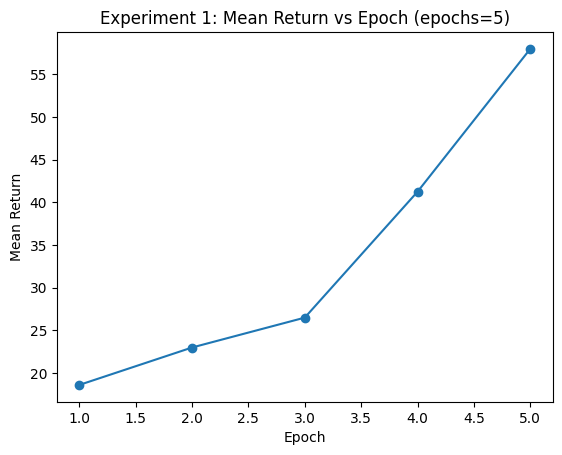

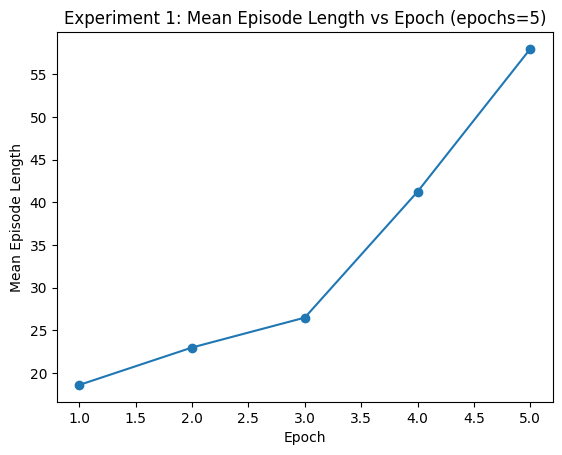

In [ ]:
mean_returns_e1, mean_lengths_e1 = run_experiment(epochs=epochs)

# Plot
plt.figure()
plt.plot(range(1, epochs + 1), mean_returns_e1, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Mean Return")
plt.title("Experiment 1: Mean Return vs Epoch (epochs=5)")
plt.show()

plt.figure()
plt.plot(range(1, epochs + 1), mean_lengths_e1, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Mean Episode Length")
plt.title("Experiment 1: Mean Episode Length vs Epoch (epochs=5)")
plt.show()

- The agent is improving consistently each epoch
- Large jump between Epoch 3 → 4 indicates the policy started stabilizing
- By Epoch 5, return nearly tripled compared to Epoch 1
- Mean Episode Length matches Return, which is expected in CartPole


- Is the agent improving meaningfully by epoch 5?  
Yes. The PPO agent shows clear and consistent learning improvement within 5 epochs. However, performance is still far from optimal CartPole performance around 200 plus. Therefore, 5 epochs allow learning to start but are insufficient for convergence to a strong policy.

# Experiment 2: Increase Hidden Layer Size

In [ ]:
# ===== Experiment 2 change =====
hidden_sizes_e2 = (128, 128)

# Rebuild actor
observation_input = keras.Input(shape=(obs_dim,), dtype=tf.float32)
x = mlp(observation_input, hidden_sizes=hidden_sizes_e2, activation=tf.tanh)
logits = layers.Dense(num_actions, activation=None)(x)
actor = keras.Model(inputs=observation_input, outputs=logits)

# Rebuild critic
observation_input_v = keras.Input(shape=(obs_dim,), dtype=tf.float32)
v = mlp(observation_input_v, hidden_sizes=hidden_sizes_e2, activation=tf.tanh)
value = layers.Dense(1, activation=None)(v)
critic = keras.Model(inputs=observation_input_v, outputs=value)

# Recreate optimizers (fresh start for fair comparison)
policy_optimizer = keras.optimizers.Adam(learning_rate=policy_learning_rate)
value_optimizer = keras.optimizers.Adam(learning_rate=value_function_learning_rate)

print("Experiment 2 networks built with hidden_sizes =", hidden_sizes_e2)

Experiment 2 networks built with hidden_sizes = (128, 128)


Epoch 01/5 | Mean Return: 21.39 | Mean Ep Length: 21.39
Epoch 02/5 | Mean Return: 21.86 | Mean Ep Length: 21.86
Epoch 03/5 | Mean Return: 23.53 | Mean Ep Length: 23.53
Epoch 04/5 | Mean Return: 22.10 | Mean Ep Length: 22.10
Epoch 05/5 | Mean Return: 23.53 | Mean Ep Length: 23.53


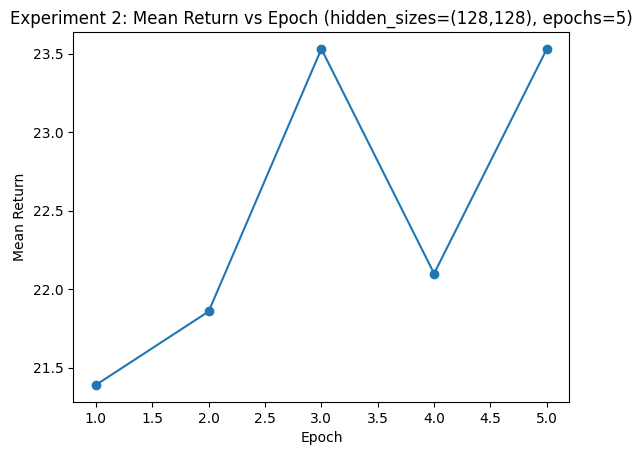

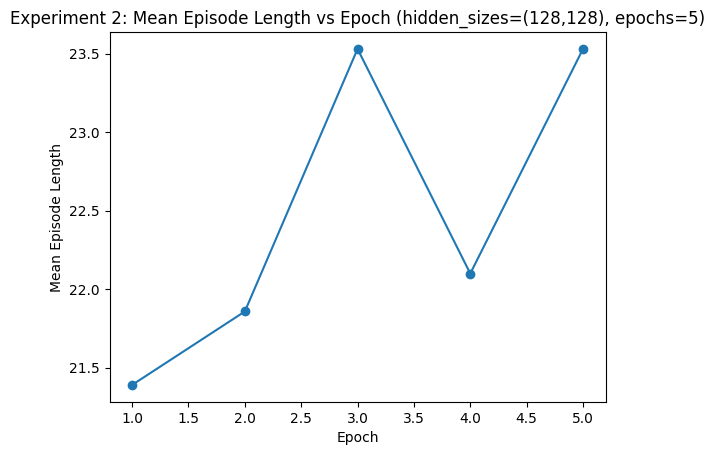

In [ ]:
# Keep epochs=5 exactly like Experiment 1
epochs_e2 = 5

mean_returns_e2, mean_lengths_e2 = run_experiment(epochs=epochs_e2)

# Plot
plt.figure()
plt.plot(range(1, epochs_e2 + 1), mean_returns_e2, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Mean Return")
plt.title("Experiment 2: Mean Return vs Epoch (hidden_sizes=(128,128), epochs=5)")
plt.show()

plt.figure()
plt.plot(range(1, epochs_e2 + 1), mean_lengths_e2, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Mean Episode Length")
plt.title("Experiment 2: Mean Episode Length vs Epoch (hidden_sizes=(128,128), epochs=5)")
plt.show()

- When increasing hidden layer size from (64,64) to (128,128) while keeping epochs = 5, the PPO agent did not show improved convergence speed.

- Mean Return remained around 21–23 across all 5 epochs, with no strong upward trend. In contrast, Experiment 1 reached a Mean Return of approximately 58 by epoch 5.


- This suggests that a larger network requires more training epochs to learn effectively. Under limited training budget, increasing model capacity may slow down apparent learning rather than improve it.

- Therefore, increasing hidden layer size did not improve convergence speed in this short training setting.

# Experiment 3: Increase Clip Ratio

In [ ]:
# ===== Experiment 3 change =====
clip_ratio_e3 = 0.4
clip_ratio = clip_ratio_e3  # overwrite the global used inside train_policy()

# Reset to baseline network size for Experiment 3
hidden_sizes_e3 = (64, 64)

# Rebuild actor
observation_input = keras.Input(shape=(obs_dim,), dtype=tf.float32)
x = mlp(observation_input, hidden_sizes=hidden_sizes_e3, activation=tf.tanh)
logits = layers.Dense(num_actions, activation=None)(x)
actor = keras.Model(inputs=observation_input, outputs=logits)

# Rebuild critic
observation_input_v = keras.Input(shape=(obs_dim,), dtype=tf.float32)
v = mlp(observation_input_v, hidden_sizes=hidden_sizes_e3, activation=tf.tanh)
value = layers.Dense(1, activation=None)(v)
critic = keras.Model(inputs=observation_input_v, outputs=value)

# Fresh optimizers
policy_optimizer = keras.optimizers.Adam(learning_rate=policy_learning_rate)
value_optimizer = keras.optimizers.Adam(learning_rate=value_function_learning_rate)

print("Experiment 3 settings:")
print(" hidden_sizes =", hidden_sizes_e3)
print(" clip_ratio   =", clip_ratio)
print(" epochs       =", 5)

Experiment 3 settings:
 hidden_sizes = (64, 64)
 clip_ratio   = 0.4
 epochs       = 5


Epoch 01/5 | Mean Return: 26.32 | Mean Ep Length: 26.32
Epoch 02/5 | Mean Return: 27.59 | Mean Ep Length: 27.59
Epoch 03/5 | Mean Return: 25.81 | Mean Ep Length: 25.81
Epoch 04/5 | Mean Return: 26.85 | Mean Ep Length: 26.85
Epoch 05/5 | Mean Return: 25.16 | Mean Ep Length: 25.16


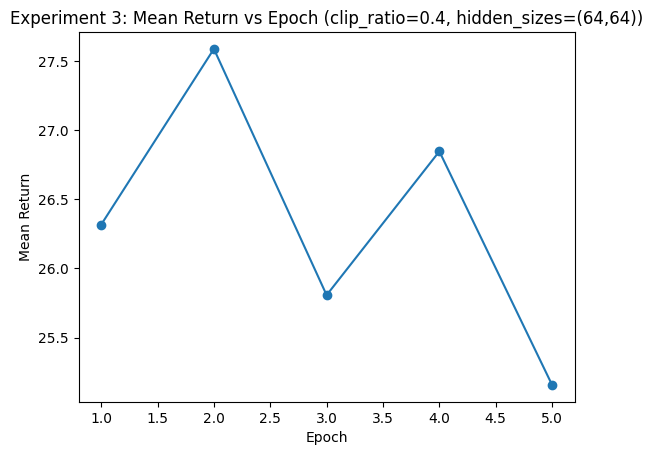

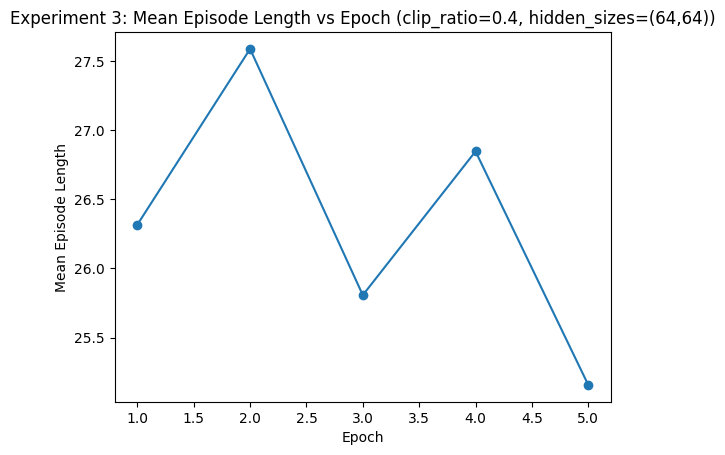

In [ ]:
epochs_e3 = 5
mean_returns_e3, mean_lengths_e3 = run_experiment(epochs=epochs_e3)

plt.figure()
plt.plot(range(1, epochs_e3 + 1), mean_returns_e3, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Mean Return")
plt.title("Experiment 3: Mean Return vs Epoch (clip_ratio=0.4, hidden_sizes=(64,64))")
plt.show()

plt.figure()
plt.plot(range(1, epochs_e3 + 1), mean_lengths_e3, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Mean Episode Length")
plt.title("Experiment 3: Mean Episode Length vs Epoch (clip_ratio=0.4, hidden_sizes=(64,64))")
plt.show()

- When increasing clip_ratio from 0.2 to 0.4, the PPO agent showed more unstable learning behavior.

- Mean Return fluctuated between 25 and 28 across epochs, without a consistent upward trend. In contrast, Experiment 1 achieved steady improvement up to approximately 58 by epoch 5.

- This indicates that allowing larger policy updates makes training more unstable. A higher clip ratio reduces the conservative constraint that PPO applies to policy updates, leading to noisier learning and weaker convergence under limited training.

- Therefore, increasing clip_ratio to 0.4 destabilised learning rather than improving performance.

# Compare 3 experiment.

| Experiment          | Key Finding                         |
| ------------------- | ----------------------------------- |
| 1. epochs=5         | Learning starts but not converged   |
| 2. hidden=(128,128) | Larger network needs more training  |
| 3. clip_ratio=0.4   | Larger clip makes learning unstable |


# Visualization

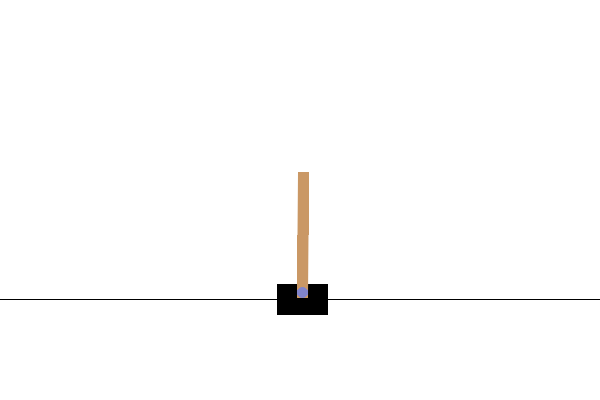

In [ ]:
!pip -q install imageio imageio-ffmpeg
import imageio
import numpy as np
import gymnasium as gym
from IPython.display import Image, display

def record_gif(actor, env_name="CartPole-v1", gif_path="cartpole.gif", max_steps=500):
    env = gym.make(env_name, render_mode="rgb_array")
    obs, _ = env.reset()
    frames = []

    for _ in range(max_steps):
        frame = env.render()
        frames.append(frame)

        logits = actor(np.array(obs, dtype=np.float32).reshape(1, -1))
        action = int(np.argmax(logits.numpy(), axis=1)[0])  # greedy action
        obs, reward, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            break

    env.close()
    imageio.mimsave(gif_path, frames, fps=30)
    return gif_path

gif_file = record_gif(actor, gif_path="ppo_cartpole.gif")
display(Image(filename=gif_file))

# Proximal Policy Optimisation (PPO) in simple, step by step terms.

### Step 1. Define the goal

You have an agent that must choose actions (left or right in CartPole).
The goal is to maximize total reward over time.

### Step 2. Start with a naive strategy

At the beginning, the agent’s policy is basically random.
It does not know what good actions look like yet.

### Step 3. Let the agent try (collect experience)

The agent interacts with the environment and records:

* what it saw (state)
* what it did (action)
* what reward it got
* whether the episode ended

This is like “playing many rounds” to gather learning data.

### Step 4. Measure how good the actions were

For each action the agent took, PPO estimates:

* was this action better than expected?
* or worse than expected?

This “better or worse” score is called **advantage**.

### Step 5. Update the strategy, but gently

Now we improve the policy so it chooses better actions more often.

But PPO’s key idea is:
**don’t change the strategy too much in one update.**

Why? Because big sudden changes can break learning.

### Step 6. Use the “proximal” rule (stay close)

PPO checks how different the new policy is compared to the old policy.

If the new policy tries to change too aggressively, PPO restricts it.

This is the meaning of “proximal”.
Stay close to the previous policy.

### Step 7. The clip ratio enforces this safety limit

PPO uses a **clip ratio** (like 0.2) to cap how much the policy is allowed to change.

* Small clip ratio → safer, more stable learning
* Large clip ratio → faster updates, but risk of instability

You actually saw this in your Experiment 3.

### Step 8. Repeat many times

The agent repeatedly:

* collects new experience
* computes advantages
* updates policy with clipping

Over time, it becomes much better.

### Step 9. Stop early if the policy is changing too much

PPO often monitors a “change size” signal (KL divergence).
If the policy shift becomes too large, it stops updating early.

This prevents learning from going off the rails.



# Understand gymnasium

In [7]:
!pip -q install gymnasium

import gymnasium as gym

# Create CartPole environment
env = gym.make("CartPole-v1")

print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

obs, _ = env.reset()
print("Step | Cart Position | Cart Velocity | Pole Angle | Pole Angular Velocity")

for step in range(10):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, _ = env.step(action)
    print(f"{step+1} | {obs[0]:.4f} | {obs[1]:.4f} | {obs[2]:.4f} | {obs[3]:.4f}")
    # print(f"  Cart Position: {obs[0]:.4f}")
    # print(f"  Cart Velocity: {obs[1]:.4f}")
    # print(f"  Pole Angle: {obs[2]:.4f}")
    # print(f"  Pole Angular Velocity: {obs[3]:.4f}")

    if terminated or truncated:
        break

Observation space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Action space: Discrete(2)
Step | Cart Position | Cart Velocity | Pole Angle | Pole Angular Velocity
1 | -0.0272 | 0.2057 | -0.0354 | -0.2951
2 | -0.0231 | 0.0111 | -0.0413 | -0.0138
3 | -0.0229 | 0.2068 | -0.0416 | -0.3192
4 | -0.0188 | 0.0123 | -0.0480 | -0.0399
5 | -0.0185 | -0.1821 | -0.0487 | 0.2373
6 | -0.0221 | -0.3765 | -0.0440 | 0.5142
7 | -0.0297 | -0.5709 | -0.0337 | 0.7927
8 | -0.0411 | -0.3754 | -0.0179 | 0.4896
9 | -0.0486 | -0.5702 | -0.0081 | 0.7766
10 | -0.0600 | -0.3750 | 0.0075 | 0.4814


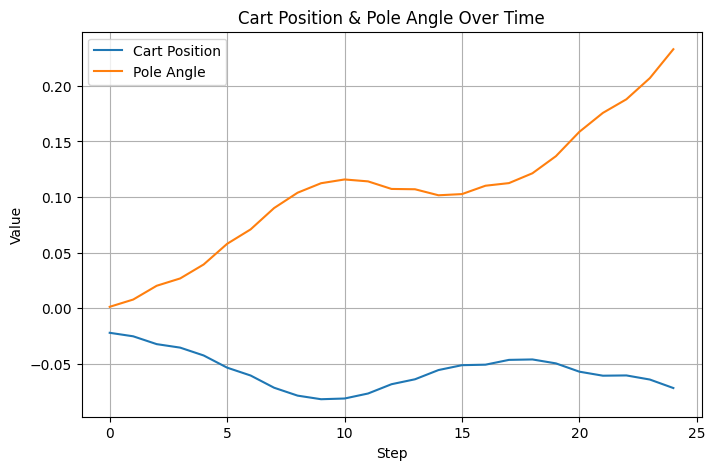

In [9]:
import gymnasium as gym
import matplotlib.pyplot as plt

env = gym.make("CartPole-v1")
obs, _ = env.reset()

positions = []
angles = []

for _ in range(100):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, _ = env.step(action)

    positions.append(obs[0])   # Cart Position
    angles.append(obs[2])      # Pole Angle

    if terminated or truncated:
        break

plt.figure(figsize=(8,5))
plt.plot(positions, label="Cart Position")
plt.plot(angles, label="Pole Angle")
plt.title("Cart Position & Pole Angle Over Time")
plt.xlabel("Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
env = gym.make("CartPole-v1")
obs, _ = env.reset()
print("obs, reward, terminated, truncated")
while True:
    action = env.action_space.sample()
    obs, reward, terminated, truncated, _ = env.step(action)
    print(obs, reward, terminated, truncated)
    if terminated or truncated:
        break

obs, reward, terminated, truncated
[-0.01356171 -0.20604527 -0.01454355  0.30550903] 1.0 False False
[-0.01768262 -0.01071912 -0.00843337  0.00827514] 1.0 False False
[-0.017897    0.18452276 -0.00826787 -0.28705662] 1.0 False False
[-0.01420654 -0.01048032 -0.014009    0.00300725] 1.0 False False
[-0.01441615 -0.20539859 -0.01394885  0.29123744] 1.0 False False
[-0.01852412 -0.01008055 -0.0081241  -0.00581193] 1.0 False False
[-0.01872573  0.18515697 -0.00824034 -0.301047  ] 1.0 False False
[-0.01502259  0.38039538 -0.01426128 -0.59631735] 1.0 False False
[-0.00741469  0.575714   -0.02618763 -0.8934581 ] 1.0 False False
[ 0.00409959  0.3809568  -0.04405679 -0.6091208 ] 1.0 False False
[ 0.01171873  0.18647754 -0.05623921 -0.33063346] 1.0 False False
[ 0.01544828  0.38235307 -0.06285188 -0.6405078 ] 1.0 False False
[ 0.02309534  0.18816106 -0.07566203 -0.36826125] 1.0 False False
[ 0.02685856  0.38427198 -0.08302726 -0.68380946] 1.0 False False
[ 0.034544    0.19039503 -0.09670345 -0.4